In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
import scipy.stats

In [14]:
df = pd.read_csv("data/trainset.csv", index_col="Region_Name")

In [15]:
dfr = df.T
dfr.rename(columns={"Region_Name":"Month"}, inplace=True)
dfr.insert(0, "Months", np.arange(1, 73))
dfr.reset_index(inplace=True)
dfr.drop(columns=["index"], inplace=True)

In [16]:
from statsmodels.tsa.arima.model import ARIMA

In [17]:
def month_mean(m, y, diff_taken = True):
    mean = 0
    if diff_taken:
        if m!=1:
            mean = y[m-2]
        for i in range(10 + m, 71, 12):
            mean = mean + y[i]
    else:
        for i in range(m - 1, 72, 12):
            mean =mean + y[i]
    mean = mean / 6
    return mean

def broadcast_month_avg(y, diff_taken = True):
    month_avg = np.zeros((12))
    month = np.zeros((71))
    if diff_taken:       
        for i in range(1, 13):
            month_avg[i-1] = month_mean(i, y)
        for j in range(1,12):
            month[j-1] = month_avg[j]
        for i in range(1, 6):
            for j in range(12):
                month[12*i+j-1] = month_avg[j]
    else:
        for i in range(1, 13):
            month_avg[i-1] = month_mean(i, y)
        month = np.zeros((72))
        for j in range(1,12):
            month[j-1] = month_avg[j]
        for i in range(0, 6):
            for j in range(12):
                month[12*i+j] = month_avg[j]
    return month

def broadcast_time_division(k, diff_taken = True):
    quarter = np.zeros((72))
    for i in range(1,int(72/k)+1):
        for j in range(1,k+1):
            quarter[k*i - j] = i
    if diff_taken:
        quarter = np.delete(quarter, 0)
    return quarter

In [18]:
def clean_data(i, k, take_diff = True, take_diff_first = True):

    y = dfr.iloc[:, i]
    #dfr.iloc[:, i].plot(figsize = (20, 5), color = "blue")
    avg, dev = y.mean(), y.std()
    y = (y - avg)/ dev
    y = y.to_frame()

    if take_diff and take_diff_first:
        y = y.diff().dropna()
        y.reset_index(drop=True, inplace=True)
        y.insert(0, 'time_grouped', broadcast_time_division(k))
        volatility = y.iloc[:, [0, 1]].groupby('time_grouped').std()
        vol = np.zeros((72))
        for i in range(1,int(72/k)+1):
            for j in range(1,k+1):
                vol[k*i - j] = volatility.iloc[:, 0][i]
        vol = np.delete(vol, 0)
        y.iloc[:, 1] = y.iloc[:, 1] / vol
        y.insert(2, 'month_avg', broadcast_month_avg(y.iloc[:, 0]))
        y.iloc[:, 1] = y.iloc[:, 1] - y.iloc[:, 2]
        # y.iloc[:, 1].plot(figsize = (20, 5), color = "green")
    
    elif take_diff and not take_diff_first:
        y.insert(0, 'time_grouped', broadcast_time_division(k, False))
        volatility = y.iloc[:, [0, 1]].groupby('time_grouped').std()
        vol = np.zeros((72))
        for i in range(1,int(72/k)+1):
            for j in range(1,k+1):
                vol[k*i - j] = volatility.iloc[:, 0][i]
        y.iloc[:, 1] = y.iloc[:, 1] / vol
        y.insert(2, 'month_avg', broadcast_month_avg(y.iloc[:, 0], False))
        y.iloc[:, 1] = y.iloc[:, 1] - y.iloc[:, 2]
        y = y.diff().dropna()
        y.reset_index(drop=True, inplace=True)
        # y.iloc[:, 1].plot(figsize = (20, 5), color = "green")

    elif not take_diff and not take_diff_first:
        y.insert(0, 'time_grouped', broadcast_time_division(k, False))
        volatility = y.iloc[:, [0, 1]].groupby('time_grouped').std()
        vol = np.zeros((72))
        for i in range(1,int(72/k)+1):
            for j in range(1,k+1):
                vol[k*i - j] = volatility.iloc[:, 0][i]
        y.iloc[:, 1] = y.iloc[:, 1] / vol
        y.insert(2, 'month_avg', broadcast_month_avg(y.iloc[:, 0], False))
        y.iloc[:, 1] = y.iloc[:, 1] - y.iloc[:, 2]
        # y.iloc[:, 1].plot(figsize = (20, 5), color = "green")
    return y.iloc[:, 1]

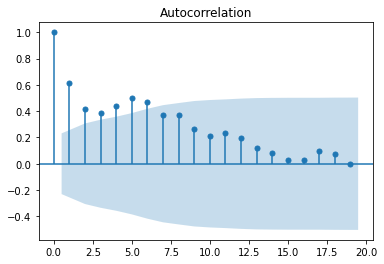

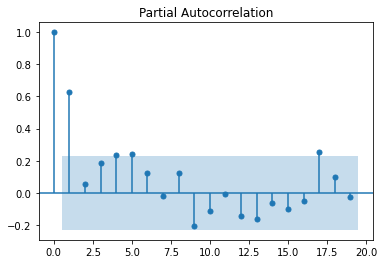

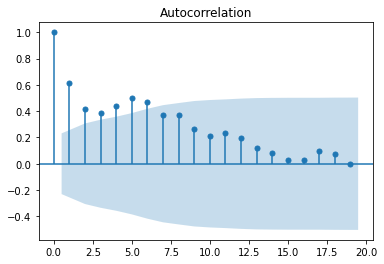

In [19]:
plot_pacf(dfr["Region 1"])
adfuller(dfr["Region 1"].diff().dropna())
plot_acf(dfr["Region 1"])

In [20]:
# Ntest = 15
# # reg = pd.DataFrame(clean_data(420, 3, take_diff=True, take_diff_first=False))
# reg = dfr.loc[:, ["Region 420"]].diff()
# train = reg[:-Ntest]
# test = reg[-Ntest:]
# # fig, ax = plt.subplots(figsize=(20, 5))
# # test

In [21]:
totsco = 0
mon = ["Month {}".format(i) for i in range(73, 88)]
dict = {"Month":mon}
fincsv = pd.DataFrame(dict)

1


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


3401.379868357713
Min Score 3401.379868357713
Max Score 3401.379868357713


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


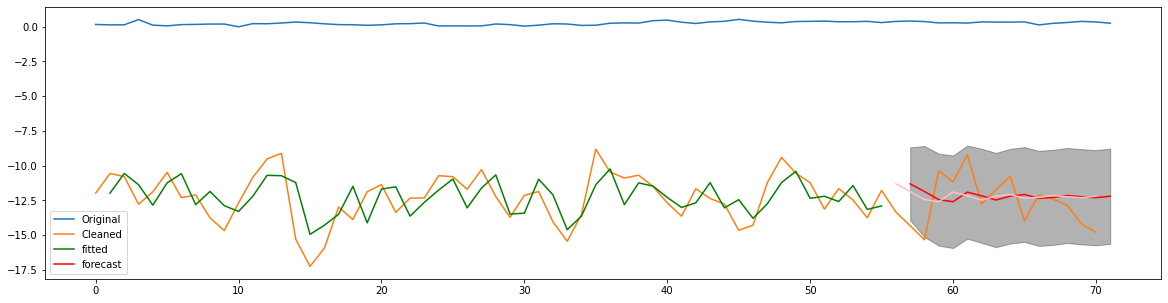

In [22]:
scoremin = 1000000
scoremax = 0
for i in range(1,2):
    print(i)
    region = "Region {}".format(i)
    reg_no = i
    Ntest = 15
    reg = pd.DataFrame(clean_data(reg_no, 3, take_diff=True, take_diff_first=True))
    # reg = dfr.loc[:, [region]]
    train = reg[:-Ntest]
    test = dfr.iloc[-Ntest:, reg_no]
    # fig, ax = plt.subplots(figsize=(20, 5))
    # test
    train_idx = dfr.index <= train.index[-1]
    test_idx = dfr.index > train.index[-1]
    # test_idx
    # train_idx
    def plot_fit_and_forecast_int(result, d, region, cleaned=False):
        fig, ax = plt.subplots(figsize=(15, 5))
        ax.plot(dfr[region], label="Original")
        if(cleaned==True): ax.plot(reg+dfr[region].median(), label="Cleaned")
        # plot the curve fitted on train set
        if(cleaned==True): train_pred = result.predict(start=train.index[d], end=train.index[-1]) + dfr[region].median()
        else: train_pred = result.predict(start=train.index[d], end=train.index[-1]) #+ dfr[region].median()

        ax.plot(train.index[d:], train_pred, color='green', label='fitted')

        # forecast the test set
        prediction_result = result.get_forecast(Ntest)
        if(cleaned==True): conf_int = prediction_result.conf_int() + dfr[region].median()
        else: conf_int = prediction_result.conf_int() #+ dfr[region].median()
        lower, upper = conf_int[f'lower {region}'], conf_int[f'upper {region}']
        if(cleaned==True): forecast = prediction_result.predicted_mean + dfr[region].median()
        else: forecast = prediction_result.predicted_mean #+ dfr[region].median()
        ax.plot(test.index, forecast, label='forecast', color='Red')
        ax.fill_between(test.index, 
                        lower, upper, 
                        color='black', alpha=0.3)
        ax.legend()
        return train_pred, forecast

    arima = ARIMA(train, order=(3,1,6))
    arima_result_811 = arima.fit()
    train_pred, forecast = plot_fit_and_forecast_int(arima_result_811, 1, region, cleaned=True)
    testarr = np.array(test)
    forecastarr = np.array(forecast)
    # print(forecast)
    forecast.plot(figsize=(20,5), color='Pink')
    fincsv["Region {}".format(i)] = forecastarr
    score = np.abs((testarr-forecastarr)/testarr)*100
    scoref = score.sum()/20
    print(scoref)
    scoremin = min(scoremin, scoref)
    scoremax = max(scoremax, scoref)
print("Min Score {}".format(scoremin))
print("Max Score {}".format(scoremax))
    # score = np.abs((testarr-forecastarr)/testarr)*100
    # totsco += score.sum()/15
    # print(totsco)

In [23]:
# print("final total score: ")
# # totsco = totsco/10
# # print(totsco)
fincsv.set_index("Month", inplace=True)
fincsv.to_csv('(316)_csv.csv')
fincsv
# fincsv.iloc[:, -5:]
# print(testarr, forecastarr)

,Region 1
Month,
Month 73,-11.312609
Month 74,-11.863535
Month 75,-12.448260
Month 76,-12.598897
Month 77,-11.907738
Month 78,-12.172040
Month 79,-12.478924
Month 80,-12.199297
Month 81,-12.080277


In [24]:
# def score(forecast, test):
#     sc = (np.abs((forecast-test.iloc[:,0])/test.iloc[:, 0]))*100
#     return sc.sum()/15
# print(score(forecast, test))
# testarr = np.array(test)
# # forecastarr = np.array(forecast)
# score = np.abs((testarr-forecastarr)/testarr)*100
# scoref = score.sum()/15
# print(scoref)
# print(testarr, forecastarr)
fincsv.set_index("Month")
fincsv.to_csv('1 500.csv')
fincsv.iloc[:, -5:]

KeyError: "None of ['Month'] are in the columns"

In [ ]:
# dfdes = dfr.describe()

In [ ]:
# mxp = 0
# for col in dfr.columns:
#     if(col=="Months"): continue
#     else:
#         adf = adfuller(dfr[col])
# #         mxp = max(mxp, adf[1])

# dfr1 = np.array(dfr["Region 1"])
# # dfr1[0] = np.inf
# np.isinf(dfr1)
# mxx=0
# id = -1
# for ind, mx in enumerate(dfdes.loc["max", "Region 1":"Region 3915"]):
#     if(mx>mxx):
#         mxx = mx
#         id = ind
# print(id)
# print(mxx)
# mnn=0
# idn = -1
# for ind, mn in enumerate(dfdes.loc["min", "Region 1":"Region 3915"]):
#     if(mn<mnn):
#         mnn = mn
#         idn = ind
# print(idn)
# print(mnn)